In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import tensorflow as tf
import zipfile
import cv2

from google.colab import drive
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = pathlib.Path('/content/drive/MyDrive/AgeDB-Updated/utkface_aligned_cropped/UTKFace')

In [4]:
if os.path.exists(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder_path, filename)

            img = cv2.imread(img_path)
            print(f"Processing image: {filename}, Shape: {img.shape}")

else:
    print(f"Folder not found at: {folder_path}")

Streaming output truncated to the last 5000 lines.
Processing image: 22_1_3_20170119153416689.jpg.chip.jpg, Shape: (200, 200, 3)
Processing image: 25_0_4_20170117195006460.jpg.chip.jpg, Shape: (200, 200, 3)
Processing image: 24_1_3_20170119171105800.jpg.chip.jpg, Shape: (200, 200, 3)
Processing image: 24_1_1_20170112234600841.jpg.chip.jpg, Shape: (200, 200, 3)
Processing image: 24_0_0_20170111181750330.jpg.chip.jpg, Shape: (200, 200, 3)
Processing image: 23_1_3_20170119164456070.jpg.chip.jpg, Shape: (200, 200, 3)
Processing image: 24_0_0_20170117150004378.jpg.chip.jpg, Shape: (200, 200, 3)
Processing image: 23_0_2_20170107213747034.jpg.chip.jpg, Shape: (200, 200, 3)
Processing image: 22_1_0_20170112233719345.jpg.chip.jpg, Shape: (200, 200, 3)
Processing image: 22_1_0_20170105184130182.jpg.chip.jpg, Shape: (200, 200, 3)
Processing image: 24_0_2_20170116161844819.jpg.chip.jpg, Shape: (200, 200, 3)
Processing image: 24_1_3_20170104231344873.jpg.chip.jpg, Shape: (200, 200, 3)
Processing im

In [ ]:
import re
import shutil
from pathlib import Path
from collections import defaultdict
import random

def extract_name_and_age(filename):
    name_without_ext = filename.rsplit('.', 1)[0]
    parts = name_without_ext.split('_')
    try:
        age = int(parts[0])
        name = '_'.join(parts[1:])
        return name, age
    except (ValueError, IndexError):
        pass
    return None, None

def rename_and_organize_images(source_folder, output_folder, age_ranges=None, rename_files=True):
    source_path = Path(source_folder)
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)
    age_categories = defaultdict(list)
    used_names = set()
    image_files = list(source_path.glob('*.png')) + list(source_path.glob('*.jpg')) + list(source_path.glob('*.jpeg'))

    for file_path in image_files:
        name, age = extract_name_and_age(file_path.name)
        if name is None or age is None:
  
            continue
        extension = file_path.suffix
        new_filename = f"{name}_{age}{extension}"
        counter = 1
        while new_filename in used_names:
            new_filename = f"{name}_{age}_{counter}{extension}"
            counter += 1
        used_names.add(new_filename)
        if age_ranges:
            category = None
            for min_age, max_age in age_ranges:
                if min_age <= age <= max_age:
                    category = f"age_{min_age}-{max_age}"
                    break
            if category is None:
                continue
        else:
            category = f"age_{age}"
        category_path = output_path / category
        category_path.mkdir(exist_ok=True)
        shutil.copy2(file_path, category_path / new_filename)
        age_categories[category].append(category_path / new_filename)
    for category, files in sorted(age_categories.items()):
        print(f"  {category}: {len(files)} images")
    return age_categories

def sample_from_categories(age_categories, sample_fraction=None, output_folder=None, seed=None):
    if seed is not None:
        random.seed(seed)
    sampled = {}
    for category, files in sorted(age_categories.items()):
        total = len(files)
        n = max(1, int(total * sample_fraction))
        sampled[category] = random.sample(files, n)
        print(f"  {category}: {n}/{total} images ({n/total*100:.1f}%)")
    if output_folder:
        output_path = Path(output_folder)
        output_path.mkdir(parents=True, exist_ok=True)
        for category, files in sampled.items():
            category_path = output_path / category
            category_path.mkdir(exist_ok=True)
            for file_path in files:
                shutil.copy2(file_path, category_path / file_path.name)
    return sampled

SOURCE_FOLDER    = "/content/drive/MyDrive/AgeDB-Updated"
ORGANIZED_FOLDER = "/content/drive/MyDrive/organized_by_age"
SAMPLED_FOLDER   = "/content/drive/MyDrive/sampled_images"

age_ranges = [
    (0, 17),
    (18, 29),
    (30, 44),
    (45, 59),
    (60, 100)
]

categories = rename_and_organize_images(SOURCE_FOLDER, ORGANIZED_FOLDER, age_ranges)

sampled = sample_from_categories(
    categories,
    sample_fraction=0.5,
    output_folder=SAMPLED_FOLDER,
    seed=42
)

Found 0 image files


In [26]:
sampled_file_path = ("/content/drive/MyDrive/sampled_images")

In [46]:
batch_size = 64
img_height = 200
img_width = 200

In [47]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  sampled_file_path,
  validation_split = 0.2,
  subset = 'training',
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 23282 files belonging to 14 classes.
Using 18626 files for training.


In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  sampled_file_path,
  validation_split = 0.2,
  subset = 'validation',
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 23282 files belonging to 14 classes.
Using 4656 files for validation.


In [49]:
age_groups = [str(age) for age in range(17, 65)]

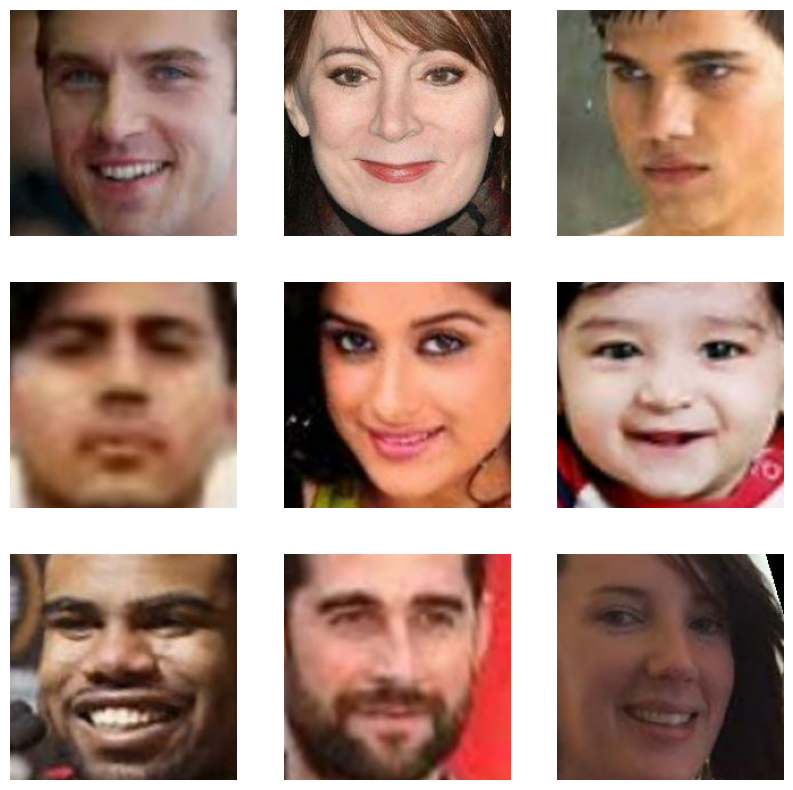

In [50]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [51]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [52]:
normalization_layer = layers.Rescaling(1./255)

In [53]:
num_classes = len(age_groups)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.2),
    layers.RandomContrast(0.2),
])

model = Sequential([
  keras.Input(shape = (img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.CenterCrop(80, 80),
  layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dense(num_classes)
])

In [54]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [55]:
epochs=20
history = model.fit(
  x = train_ds,
  validation_data = val_ds,
  batch_size = 64,
  epochs = epochs
)

Epoch 1/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 95s 196ms/step - accuracy: 0.3184 - loss: 2.3246 - val_accuracy: 0.3327 - val_loss: 2.1548
Epoch 2/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.3289 - loss: 2.1598 - val_accuracy: 0.3318 - val_loss: 2.1066
Epoch 3/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 46s 157ms/step - accuracy: 0.3303 - loss: 2.0984 - val_accuracy: 0.3464 - val_loss: 2.0102
Epoch 4/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 46s 158ms/step - accuracy: 0.3371 - loss: 2.0457 - val_accuracy: 0.3520 - val_loss: 1.9737
Epoch 5/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 46s 158ms/step - accuracy: 0.3418 - loss: 1.9936 - val_accuracy: 0.3574 - val_loss: 1.9347
Epoch 6/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 47s 161ms/step - accuracy: 0.3523 - loss: 1.9563 - val_accuracy: 0.3632 - val_loss: 1.9094
Epoch 7/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.3595 - loss: 1.9175 - val_accuracy: 0.3550 - val_loss: 1.9319
Epoch 8/20
292/292 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.3601 - loss: 1

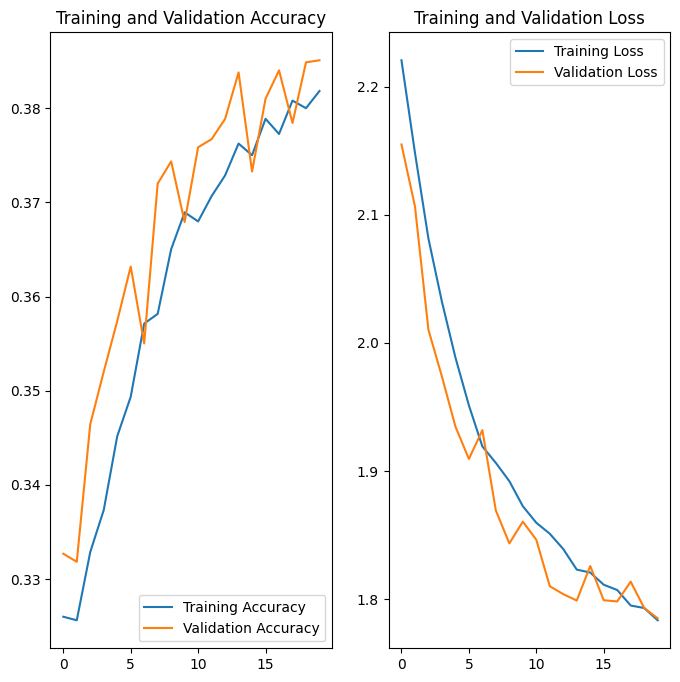

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
model.save('/content/drive/MyDrive/image_model.keras')

In [58]:
model = keras.models.load_model("/content/drive/MyDrive/image_model.keras")

In [59]:
test_url = "https://directory.mendoza.nd.edu/media/1153/sberry5.jpg?anchor=center&mode=crop&width=250&height=250&rnd=131916914060000000"

test_path = tf.keras.utils.get_file(origin = test_url)

img = keras.preprocessing.image.load_img(
    test_path, target_size = (img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(age_groups[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
This image most likely belongs to 30 with a 34.01 percent confidence.


In [61]:
import requests

TOKEN = "patNEhaR6irImRHBv.bee3c6bfc1a18d04e749198108a57ed3008c922aaefa591421a666b8a023107d"
BASE_ID = "appZRo38MkgOqKnTh"
TABLE_ID = "tblHnzA0glJWQgYhF"

url = f"https://api.airtable.com/v0/{BASE_ID}/{TABLE_ID}"
headers = {"Authorization": f"Bearer {TOKEN}"}

response = requests.get(url, headers=headers)
records = response.json()["records"]

all_urls = []

for record in records:
    fields = record["fields"]
    for field_name, field_value in fields.items():
        if isinstance(field_value, list):
            for item in field_value:
                if isinstance(item, dict) and "url" in item:
                    all_urls.append(item["url"])

print(all_urls)

['https://v5.airtableusercontent.com/v3/u/50/50/1772179200000/Nc4eVZqiavS5k7-EHzQvQQ/7eYKemoqQ8kbPxUJcr-BjOW7CdMi8X5UJ_FzPyzHrVchmEGhrODR-fkf0UsXDIJOlDChmrMb08p14FCseeXBMVyt66syq9F9X48mk8xG0W35ejPn_mhLv8TCKsS_uINmi51RUXNAG2CF5HdSb3umbqXr9svt1BZkfncMX1hLUk0/77g5URlpduLUbjtLmYEMLHLJMnsUzBSe3N5Ngp3i8Gg', 'https://v5.airtableusercontent.com/v3/u/50/50/1772179200000/8qC2iwr-IsAi8Tc2UvbMXQ/m582q8IbJPA1dJWRtIc7XSTGdpUkWPbEVQTa5dtJ6cLqKTkHr5aWY6po9dWiH-Ec3gIWBOLfjdKnYOLYPrIL1JFRJX4Z8RHYjVGej8KeUFUL1xThaxNQDwXRebTjhQmU-9EnngS-jLTqiaS6q5iew2n49TaHm0njEPeAjsSizOk/S5tF6G72noI4PQRiuNQnJB08Vd6OZSa6-Q6QP_FKgD4', 'https://v5.airtableusercontent.com/v3/u/50/50/1772179200000/AK35er15pESc2thAUirjlA/JvLrokus5IAHIqE0gdTGYNmWgrB8PQy-1PfhDY5Dire-lX1VvBEdBGATt-PUmxa904-k5fi9oL2cv87955iT_HZeC4LrMZXJnIo6xzaL37maF_-9keN32yQzg3ygHz1PgCMsl7AIDoSxWY4-mNw1Sna3-U39boiRyvHgj_jHG2U/JoaSoUa2kFaT4afb8fy22Hks8Jd3lzMabR6cyFVxlEo', 'https://v5.airtableusercontent.com/v3/u/50/50/1772179200000/cv9XrUsm5iQC-dlFI5c7TQ/jM04UwXhi

In [62]:
for url in all_urls:
    test_path = tf.keras.utils.get_file(origin=url)

    img = keras.preprocessing.image.load_img(
        test_path, target_size=(img_height, img_width)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This person is most likely {} years old with a {:.2f} percent confidence."
        .format(age_groups[np.argmax(score)], 100 * np.max(score))
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
This person is most likely 30 years old with a 57.87 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
This person is most likely 20 years old with a 23.84 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
This person is most likely 30 years old with a 39.96 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
This person is most likely 30 years old with a 65.37 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
This person is most likely 20 years old with a 36.75 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
This person is most likely 30 years old with a 60.27 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
This person is most likely 18 years old with a 57.78 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
This person is most likely 30 years old with a 70.95 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
This person is most likely 30 years old with a 78.36 percent confidence.
1